In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFont
from scipy.ndimage import shift

# import res_utils as ru

np.random.seed(12345)

%matplotlib inline
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'text.usetex': False})
np.set_printoptions(precision=3)

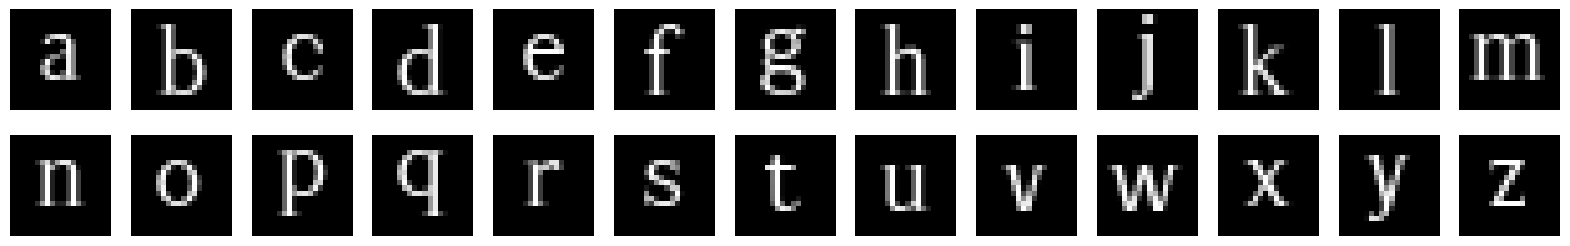

In [2]:
patch_size = [20,20]

font = ImageFont.truetype(os.path.join('ARROW.ttf'), size=18)

letters = 'abcdefghijklmnopqrstuvwxyz'

font_ims = []
fim_size = (patch_size[0], patch_size[1], 3)

for l in letters:
    font_obj = font.getmask(l)

    imtext = np.array(font_obj)
    imsize = font_obj.size  #font.getsize(l)

    imtext = np.tile(imtext.reshape((imsize[1], imsize[0], 1)), (1, 1, 3))
    imtext = imtext[:patch_size[0], :patch_size[1], :]

    imsize = imtext.shape

    fim = np.zeros(fim_size)

    fimr = int(np.floor((fim_size[0] - imsize[0]) / 2))
    fimc = int(np.floor((fim_size[1] - imsize[1]) / 2))

    fim[fimr:(fimr + imsize[0]), fimc:(fimc + imsize[1]), :] = imtext / 255

    font_ims.append(fim)
plt.figure(figsize=(20,3))
for i in range(len(letters)):
#     
    plt.subplot(2, len(letters)//2, i+1)
    plt.imshow(font_ims[i], interpolation='none')
    plt.axis('off')

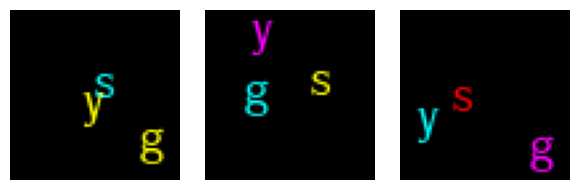

In [47]:
import random

# Define the colors
colors_dict = {
    'red': [1, 0, 0], 'green': [0, 1, 0], 'blue': [0, 0, 1],
    'cyan': [0, 1, 1], 'magenta': [1, 0, 1], 'yellow': [1, 1, 0], 'white': [1, 1, 1]
}
color_names = list(colors_dict.keys())

# Create 3 example images
result_images = []
ind_list = [6,24,18]
for _ in range(3):
    canvas = np.zeros((64, 64, 3))
    used_positions = []
    for _ in range(3):
        idx = ind_list[_]#random.randint(0, len(letters) - 1)
        letter_img = font_ims[idx]
        color = random.choice(color_names)
        color_vec = np.array(colors_dict[color])

        # Colorize
        colored_letter = letter_img * color_vec

        # Random position
        x = random.randint(0, 63)
        y = random.randint(0, 63)
        h, w = letter_img.shape[:2]
        x0 = np.clip(x - h // 2, 0, 64 - h)
        y0 = np.clip(y - w // 2, 0, 64 - w)

        # Paste letter
        canvas[x0:x0+h, y0:y0+w] += colored_letter
        canvas = np.clip(canvas, 0, 1)

    result_images.append(canvas)

# Display results
plt.figure(figsize=(6,2))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(result_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

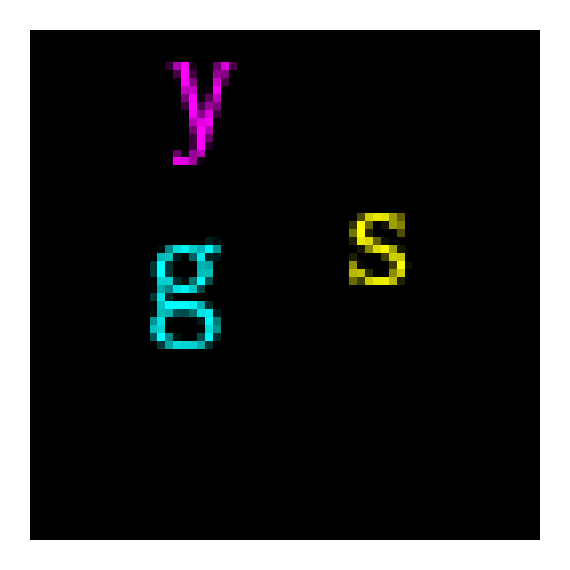

In [94]:
plt.figure(figsize=(2,2),dpi=300)
for i in [1]:#range(3):
#     plt.subplot(1, 3, i+1)
    plt.imshow(result_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

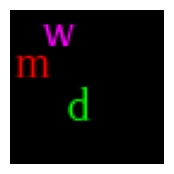

In [27]:
n_letters = len(letters)
n_colors = len(color_names)
img_size = 64

# Define pre-synaptic representation size
input_size = (n_letters + n_colors + img_size * 2)  # 26 + 7 + 64 + 64 = 161

# Initialize 10,000 post-synaptic neurons with zero weights
n_post = 20000
W_ff = np.zeros((n_post, input_size*3))
W_fb = np.zeros((input_size*3, n_post))


def sample_letter():
    return (
        random.randint(0, n_letters - 1),
        random.randint(0, n_colors - 1),
        random.randint(0, img_size - 1),
        random.randint(0, img_size - 1)
    )

letters_info = [sample_letter() for _ in range(3)]

canvas = np.zeros((img_size, img_size, 3))
for letter_idx, color_idx, x, y in letters_info:
    letter_img = font_ims[letter_idx]
    color_vec = np.array(colors_dict[color_names[color_idx]])
    colored_letter = letter_img * color_vec
    h, w = letter_img.shape[:2]
    x0 = np.clip(x - h // 2, 0, img_size - h)
    y0 = np.clip(y - w // 2, 0, img_size - w)
    canvas[x0:x0+h, y0:y0+w] += colored_letter
    canvas = np.clip(canvas, 0, 1)

plt.figure(figsize=(2, 2))
plt.imshow(canvas)
plt.axis('off')
plt.show()

def encode_letter(letter_idx, color_idx, x, y):
    vec = np.zeros(input_size)
    vec[letter_idx] = 1  # one-hot letter
    vec[n_letters + color_idx] = 1  # one-hot color
    vec[n_letters + n_colors + x] = 1  # x position
    vec[n_letters + n_colors + img_size + y] = 1  # y position
    return vec

full_input = np.concatenate([
    encode_letter(letter_idx, color_idx, x, y)
    for letter_idx, color_idx, x, y in letters_info
])

# Parallel update to 0.5% of post-synaptic neurons
pre_active = full_input == 1
selected_neurons = np.random.choice(n_post, size=50, replace=False)
weights = W_ff[selected_neurons]

set_to_1 = np.logical_and(pre_active, weights == 0)
set_to_0 = np.logical_and(pre_active, weights == 1)

weights[set_to_1] = 1
weights[set_to_0] = 0
W_ff[selected_neurons] = weights

In [100]:
def wta_decode_full(reconstruct):
    decoded = np.zeros_like(reconstruct)
    for part in range(3):  # Three letters
        base = part * input_size

        # Decode letter
        i = np.argmax(reconstruct[base : base + n_letters])
        decoded[base + i] = 1

        # Decode color
        offset = base + n_letters
        i = np.argmax(reconstruct[offset : offset + n_colors])
        decoded[offset + i] = 1

        # Decode x position
        offset += n_colors
        i = np.argmax(reconstruct[offset : offset + img_size])
        decoded[offset + i] = 1

        # Decode y position
        offset += img_size
        i = np.argmax(reconstruct[offset : offset + img_size])
        decoded[offset + i] = 1

    return decoded


In [193]:
def generate_dataset_no_repeat_letter_pos(n_images, n_letters, n_colors, img_size, rng=None):
    """
    Build a dataset where each image has 3 tuples: (letter, color, x, y).
    Dataset-wide constraint: a given (letter, x, y) appears at most once
    across the ENTIRE dataset (color does NOT matter).
    """
    if rng is None:
        rng = random

    # Feasibility: total unique (letter, x, y) combos
    total_slots = n_letters * img_size * img_size
    max_images = total_slots // 3
    if n_images > max_images:
        raise ValueError(
            f"Requested {n_images} images but the maximum under the "
            f"(letter, x, y) uniqueness constraint is {max_images} "
            f"(= {n_letters} * {img_size} * {img_size} // 3)."
        )

    used_letter_pos = set()   # tracks (letter, x, y) seen anywhere in the dataset
    dataset = []

    for _ in range(n_images):
        letters_info = []
        tries = 0
        while len(letters_info) < 3:
            tries += 1
            if tries > 1_000_000:
                raise RuntimeError("Sampling stalled; too few remaining (letter, x, y) slots.")

            letter = rng.randint(0, n_letters - 1)
            color  = rng.randint(0, n_colors - 1)
            x      = rng.randint(0, img_size - 1)
            y      = rng.randint(0, img_size - 1)

            key = (letter, x, y)
            if key in used_letter_pos:
                continue  # already used somewhere in the dataset

            used_letter_pos.add(key)
            letters_info.append((letter, color, x, y))

        dataset.append(letters_info)

    return dataset

In [195]:
n_letters * img_size * img_size//3

35498

In [198]:
from tqdm.notebook import tqdm

def wta_decode_full(reconstruct):
    decoded = np.zeros_like(reconstruct)
    for part in range(3):  # Three letters
        base = part * input_size

        # Decode letter
        i = np.argmax(reconstruct[base : base + n_letters])
        decoded[base + i] = 1

        # Decode color
        offset = base + n_letters
        i = np.argmax(reconstruct[offset : offset + n_colors])
        decoded[offset + i] = 1

        # Decode x position
        offset += n_colors
        i = np.argmax(reconstruct[offset : offset + img_size])
        decoded[offset + i] = 1

        # Decode y position
        offset += img_size
        i = np.argmax(reconstruct[offset : offset + img_size])
        decoded[offset + i] = 1

    return decoded

def encode_letter(letter_idx, color_idx, x, y):
        
    vec = np.zeros(input_size)
    if letter_idx!=None:
        vec[letter_idx] = 1  # one-hot letter
    if color_idx!=None:
        vec[n_letters + color_idx] = 1  # one-hot color
    if x!=None:
        vec[n_letters + n_colors + x] = 1  # x position
    if y!=None:
        vec[n_letters + n_colors + img_size + y] = 1  # y position
    return vec

n_letters = len(letters)
n_colors = len(color_names)
img_size = 64

# Define pre-synaptic representation size
input_size = (n_letters + n_colors + img_size * 2)  # 26 + 7 + 64 + 64 = 161

# Initialize 10,000 post-synaptic neurons with zero weights
all_res = []
all_correct = []
np.arange(2000,20000,500).tolist()
x_range = [1,10,100,200,500,1000,2000,5000,10000,20000]# + np.arange(1000,3001,1000).tolist()
np.save('BU_x_range_10000_0_0005',x_range)

for sample_size in x_range:
    n_post = 10000
    p=0.0005
    W_ff = np.zeros((n_post, input_size*3))
    W_fb = np.zeros((input_size*3, n_post))
    
    all_data = generate_dataset_no_repeat_letter_pos(
        n_images=sample_size,
        n_letters=n_letters,
        n_colors=n_colors,
        img_size=img_size,
    )

    # Training

    for letters_info in tqdm(all_data, desc="training"):
        
        full_input = np.concatenate([
            encode_letter(letter_idx, color_idx, x, y)
            for letter_idx, color_idx, x, y in letters_info
        ])

        pre_active = full_input == 1
        selected_neurons = (np.random.rand(n_post)<=p)#  np.random.choice(n_post, size=int(n_post*p), replace=True)
        weights_ff = W_ff[selected_neurons]
        weights_fb = W_fb[:,selected_neurons]

        set_to_1 = np.logical_and(pre_active, weights_ff == 0)
        set_to_0 = np.logical_and(pre_active, weights_ff == 1)
        weights_ff[set_to_1] = 1
        weights_ff[set_to_0] = 0
        W_ff[selected_neurons] = weights_ff

        weights_fb[set_to_1.T] = 1
        W_fb[:,selected_neurons] = weights_fb

    
    # Inference:

    res = []
    for data in tqdm(all_data, desc = 'testing'):
        for rank, (letter_idx, color_idx, x, y) in enumerate(data):
            if rank == 0:
                letter_code = encode_letter(letter_idx, None, x, y)
            full_input_cue = np.concatenate([letter_code, np.zeros(input_size),np.zeros(input_size)])
            break

        full_input = np.concatenate([
            encode_letter(letter_idx, color_idx, x, y)
            for letter_idx, color_idx, x, y in data
        ])
        target = full_input>0
        reconstruct = W_fb@(((W_ff@full_input_cue)>2).astype('float'))
        reconstruct_wta = wta_decode_full(reconstruct)

        res += [np.sum(target==reconstruct_wta)/len(target)]
    print(np.mean(res), ((np.array(res)==1).sum()/len(res)))
    all_res += [np.mean(res)]
    all_correct += [((np.array(res)==1).sum()/len(res))]
    np.save('BU_all_correct_10000_0_0005',all_correct)
        
    


training:   0%|          | 0/1 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/10 [00:00<?, ?it/s]

testing:   0%|          | 0/10 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/100 [00:00<?, ?it/s]

testing:   0%|          | 0/100 [00:00<?, ?it/s]

0.9995031055900622 0.99


training:   0%|          | 0/200 [00:00<?, ?it/s]

testing:   0%|          | 0/200 [00:00<?, ?it/s]

0.9990269151138716 0.98


training:   0%|          | 0/500 [00:00<?, ?it/s]

testing:   0%|          | 0/500 [00:00<?, ?it/s]

0.9989813664596274 0.97


training:   0%|          | 0/1000 [00:00<?, ?it/s]

testing:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9992215320910973 0.964


training:   0%|          | 0/2000 [00:00<?, ?it/s]

testing:   0%|          | 0/2000 [00:00<?, ?it/s]

0.9987267080745341 0.9225


training:   0%|          | 0/5000 [00:00<?, ?it/s]

testing:   0%|          | 0/5000 [00:00<?, ?it/s]

0.9937325051759835 0.553


training:   0%|          | 0/10000 [00:00<?, ?it/s]

testing:   0%|          | 0/10000 [00:00<?, ?it/s]

0.9792124223602484 0.0449


training:   0%|          | 0/20000 [00:00<?, ?it/s]

testing:   0%|          | 0/20000 [00:00<?, ?it/s]

0.9671950310559004 5e-05


(0.0, 103.5)

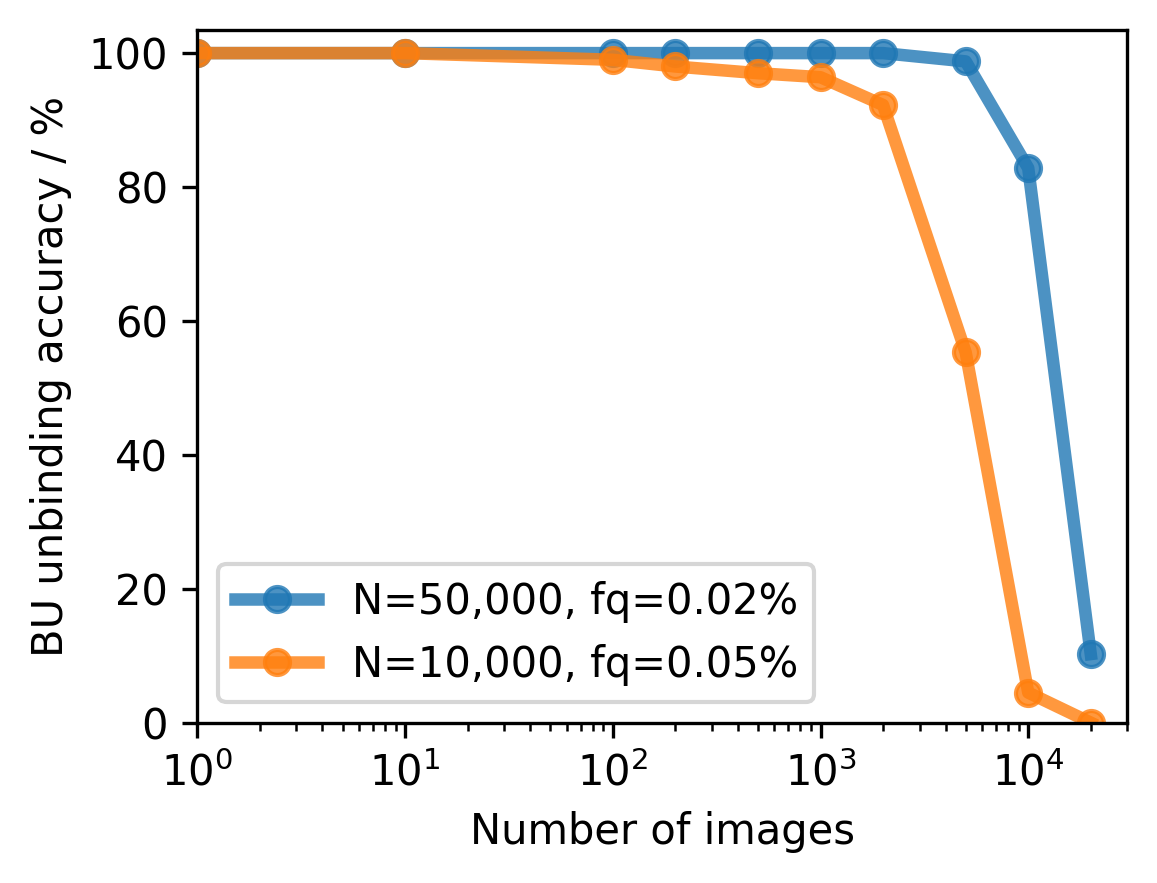

In [199]:
plt.figure(figsize=(4,3), dpi=300)
# x_10000_0_005 = np.load('BU_x_range_10000_0_005.npy')
# all_correct_10000_0_005 = np.load('BU_all_correct_10000_0_005.npy')
# x_10000_0_0025 = np.load('BU_x_range_10000_0_0025.npy')
# all_correct_10000_0_0025 = np.load('BU_all_correct_10000_0_0025.npy')
# x_20000_0_0025 = np.load('BU_x_range_20000_0_0025.npy')
# all_correct_20000_0_0025 = np.load('BU_all_correct_20000_0_0025.npy')
x_10000_0_0005 = np.load('BU_x_range_10000_0_0005.npy')
all_correct_10000_0_0005 = np.load('BU_all_correct_10000_0_0005.npy')
x_50000_0_0002 = np.load('BU_x_range_50000_0_0002.npy')
all_correct_50000_0_0002 = np.load('BU_all_correct_50000_0_0002.npy')
plt.plot(x_50000_0_0002,np.array(all_correct_50000_0_0002)*100,marker='o',lw=3,label='N=50,000, fq=0.02%',alpha=.8)
plt.plot(x_10000_0_0005,np.array(all_correct_10000_0_0005)*100,marker='o',lw=3,label='N=10,000, fq=0.05%',alpha=.8)

# plt.plot(x_10000_0_0025,
#          np.array(all_correct_10000_0_0025)*100,marker='o',lw=3,label='N=10,000, fq=0.25%',alpha=.8)
# plt.plot(x_20000_0_0025,
#          np.array(all_correct_20000_0_0025)*100,marker='o',lw=3,label='N=20,000, fq=0.25%',alpha=.8)

# plt.plot(x_10000_0_005,
#          np.array(all_correct_10000_0_005)*100,marker='o',lw=3,label='N=10,000, fq=0.5%',alpha=.8)
# plt.plot([1,300000],[95.2763904,95.2763904],'--',c='black')

plt.xscale('log')
plt.xlim(1,30000)
plt.legend()
plt.xlabel('Number of images')
plt.ylabel('BU unbinding accuracy / %')

plt.ylim(0.,103.5)

In [181]:
from tqdm.notebook import tqdm

n_letters = len(letters)
n_colors = len(color_names)
img_size = 64

# Define pre-synaptic representation size
input_size = (n_letters + n_colors + img_size * 2)  # 26 + 7 + 64 + 64 = 161

# Initialize 10,000 post-synaptic neurons with zero weights
all_res = []
all_correct = []
np.arange(2000,20000,500).tolist()
for sample_size in [1,10,100,1000,10000,20000,50000,100000,200000,500000]:#+np.arange(100000,200001,10000).tolist():
    n_post = 20000
    p=0.0005
    W_ff = np.zeros((n_post, input_size*3))
    W_fb = np.zeros((input_size*3, n_post))

    # Training
    all_data = []
    for i in tqdm(range(sample_size), desc='training'):
        letters_info = [sample_letter() for _ in range(3)]
        all_data += [letters_info]
        full_input = np.concatenate([
            encode_letter(letter_idx, color_idx, x, y)
            for letter_idx, color_idx, x, y in letters_info
        ])

        pre_active = full_input == 1
        selected_neurons = (np.random.rand(n_post)<=p)#  np.random.choice(n_post, size=int(n_post*p), replace=True)
        weights_ff = W_ff[selected_neurons]
        weights_fb = W_fb[:,selected_neurons]

        set_to_1 = np.logical_and(pre_active, weights_ff == 0)
        set_to_0 = np.logical_and(pre_active, weights_ff == 1)
        weights_ff[set_to_1] = 1
        weights_ff[set_to_0] = 0
        W_ff[selected_neurons] = weights_ff

        weights_fb[set_to_1.T] = 1
        W_fb[:,selected_neurons] = weights_fb

    def encode_letter(letter_idx, color_idx, x, y):
        vec = np.zeros(input_size)
        vec[letter_idx] = 1  # one-hot letter
        vec[n_letters + color_idx] = 1  # one-hot color
        vec[n_letters + n_colors + x] = 1  # x position
        vec[n_letters + n_colors + img_size + y] = 1  # y position
        return vec
    # Inference:
    # print((W_fb@W_ff@full_input)>0)
    # print(full_input>0)
    res = []
    for data in tqdm(all_data, desc = 'testing'):
        full_input = np.concatenate([
            encode_letter(letter_idx, color_idx, x, y)
            for letter_idx, color_idx, x, y in data
        ])
        target = full_input>0
        reconstruct = W_fb@(((W_ff@full_input)>6).astype('float'))
        reconstruct_wta = wta_decode_full(reconstruct)

        res += [np.sum(target==reconstruct_wta)/len(target)]
    print(np.mean(res), ((np.array(res)==1).sum()/len(res)))
    all_res += [np.mean(res)]
    all_correct += [((np.array(res)==1).sum()/len(res))]
#     np.save('all_correct_50000_0_0002',all_correct)
        
    


training:   0%|          | 0/1 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/10 [00:00<?, ?it/s]

testing:   0%|          | 0/10 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/100 [00:00<?, ?it/s]

testing:   0%|          | 0/100 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/1000 [00:00<?, ?it/s]

testing:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/10000 [00:00<?, ?it/s]

testing:   0%|          | 0/10000 [00:00<?, ?it/s]

0.9999792960662526 0.9951


training:   0%|          | 0/20000 [00:00<?, ?it/s]

testing:   0%|          | 0/20000 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/50000 [00:00<?, ?it/s]

testing:   0%|          | 0/50000 [00:00<?, ?it/s]

0.9998589648033126 0.96628


training:   0%|          | 0/100000 [00:00<?, ?it/s]

testing:   0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
np.load('all_correct_50000_0_0002.npy')

In [149]:
all_correct_10000_0_0005 = np.load('all_correct_10000_0_0005.npy')

[1.0, 1.0, 1.0, 0.9999875776397515, 0.999992960662526, 1.0, 1.0, 1.0, 0.9981007660455488, 0.9892807619047623]


In [159]:
x_50000_0_0002 = [1,10,100,1000,10000,20000,50000,100000,200000,500000]
np.save('x_correct_50000_0_0002',x_50000_0_0002)
np.save('all_correct_50000_0_0002',all_correct)

In [177]:
all_correct_10000_0_0005

array([1.   , 1.   , 1.   , 0.977, 0.998, 1.   , 1.   , 0.994, 0.935,
       0.527, 0.188, 0.102, 0.027, 0.023])

In [74]:
all_correct_10000_0_0005

array([1.   , 0.9  , 0.98 , 0.977, 0.998, 1.   , 1.   , 0.994, 0.935,
       0.527, 0.188, 0.102, 0.027, 0.023])

In [171]:
x_10000_0_005 = np.load('x_correct_10000_0_005.npy')
x_20000_0_0025 = np.load('x_correct_20000_0_0025.npy')
x_10000_0_0025 = np.load('x_correct_10000_0_0025.npy')
x_10000_0_0005 = np.load('x_correct_10000_0_0005.npy')
x_50000_0_0002 = np.load('x_correct_50000_0_0002.npy')
all_correct_10000_0_005 = np.load('all_correct_10000_0_005.npy')
all_correct_20000_0_0025 = np.load('all_correct_20000_0_0025.npy')
all_correct_10000_0_0025 = np.load('all_correct_10000_0_0025.npy')
all_correct_10000_0_0005 = np.load('all_correct_10000_0_0005.npy')
all_correct_50000_0_0002 = [1,1,1, 0.997, 0.998,1,1,1,0.6,0.02]#np.load('all_correct_50000_0_0002.npy')

In [172]:
x_10000_0_0005=[1,10,100,1000,10000]+np.arange(20000,100001,10000).tolist()
all_correct_10000_0_0005 = [ 1.0, 1.0, 0.9999875776397515, 0.999992960662526, 1.0, 1.0, 1.0, 0.994, 0.935,0.527, 0.188, 0.102, 0.027, 0.023]
len(x_10000_0_0005)
# len(all_correct_10000_0_0005)

14

In [173]:
all_correct_50000_0_0002

[1, 1, 1, 0.997, 0.998, 1, 1, 1, 0.6, 0.02]

(90.0, 100.5)

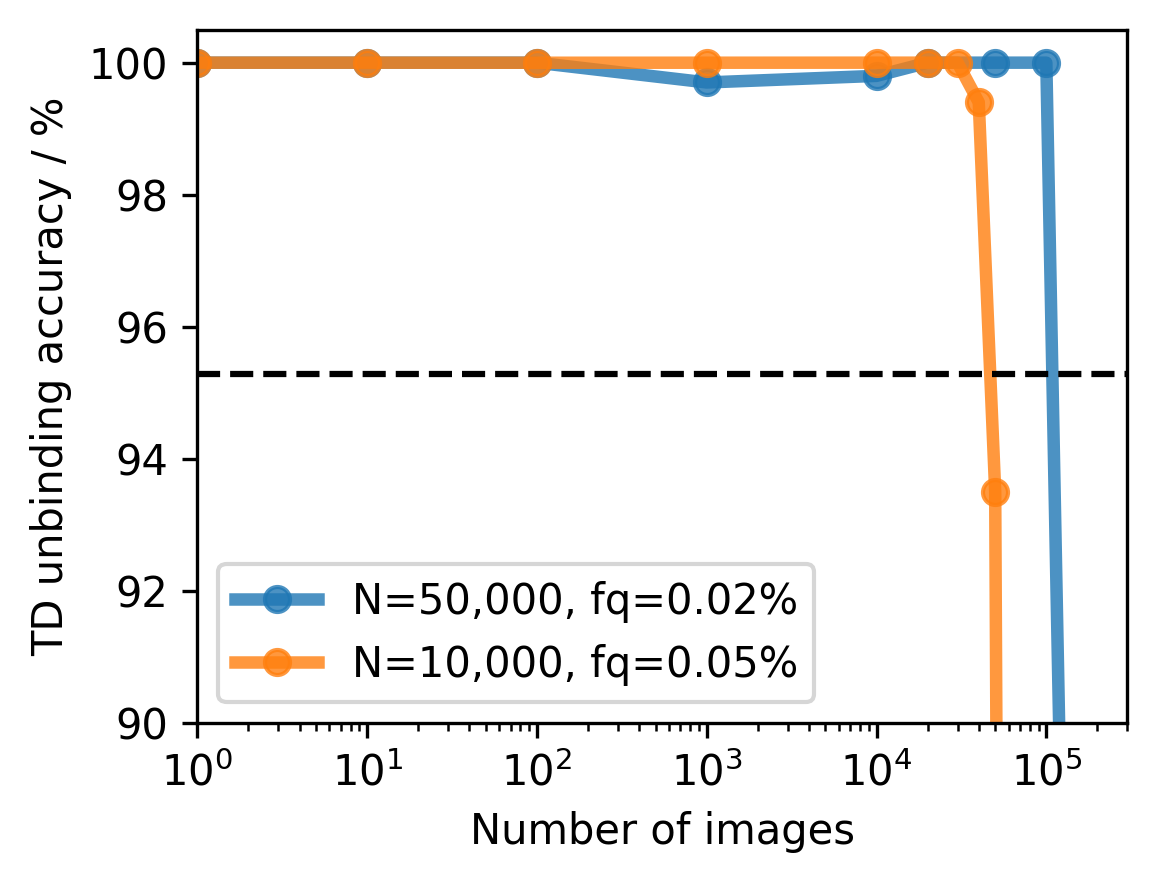

In [179]:
plt.figure(figsize=(4,3), dpi=300)

plt.plot(x_50000_0_0002,np.array(all_correct_50000_0_0002)*100,marker='o',lw=3,label='N=50,000, fq=0.02%',alpha=.8)
plt.plot(x_10000_0_0005,np.array(all_correct_10000_0_0005)*100,marker='o',lw=3,label='N=10,000, fq=0.05%',alpha=.8)
# plt.plot(x_10000_0_0025[::3],
#          np.array(all_correct_10000_0_0025[::3])*100,marker='o',lw=3,label='N=10,000, fq=0.25%',alpha=.8)
# plt.plot(x_20000_0_0025[::3],
#          np.array(all_correct_20000_0_0025[::3])*100,marker='o',lw=3,label='N=20,000, fq=0.25%',alpha=.8)
# plt.plot(x_10000_0_005,
#          np.array(all_correct_10000_0_005)*100,marker='o',lw=3,label='N=10,000, fq=0.5%',alpha=.8)
plt.plot([1,300000],[95.2763904,95.2763904],'--',c='black')

plt.xscale('log')
plt.xlim(1,300000)
plt.legend()#, bbox_to_anchor=(0.5, 1.35), ncol=2)
plt.xlabel('Number of images')
plt.ylabel('TD unbinding accuracy / %')

plt.ylim(90.,100.5)

(0.0, 103.0)

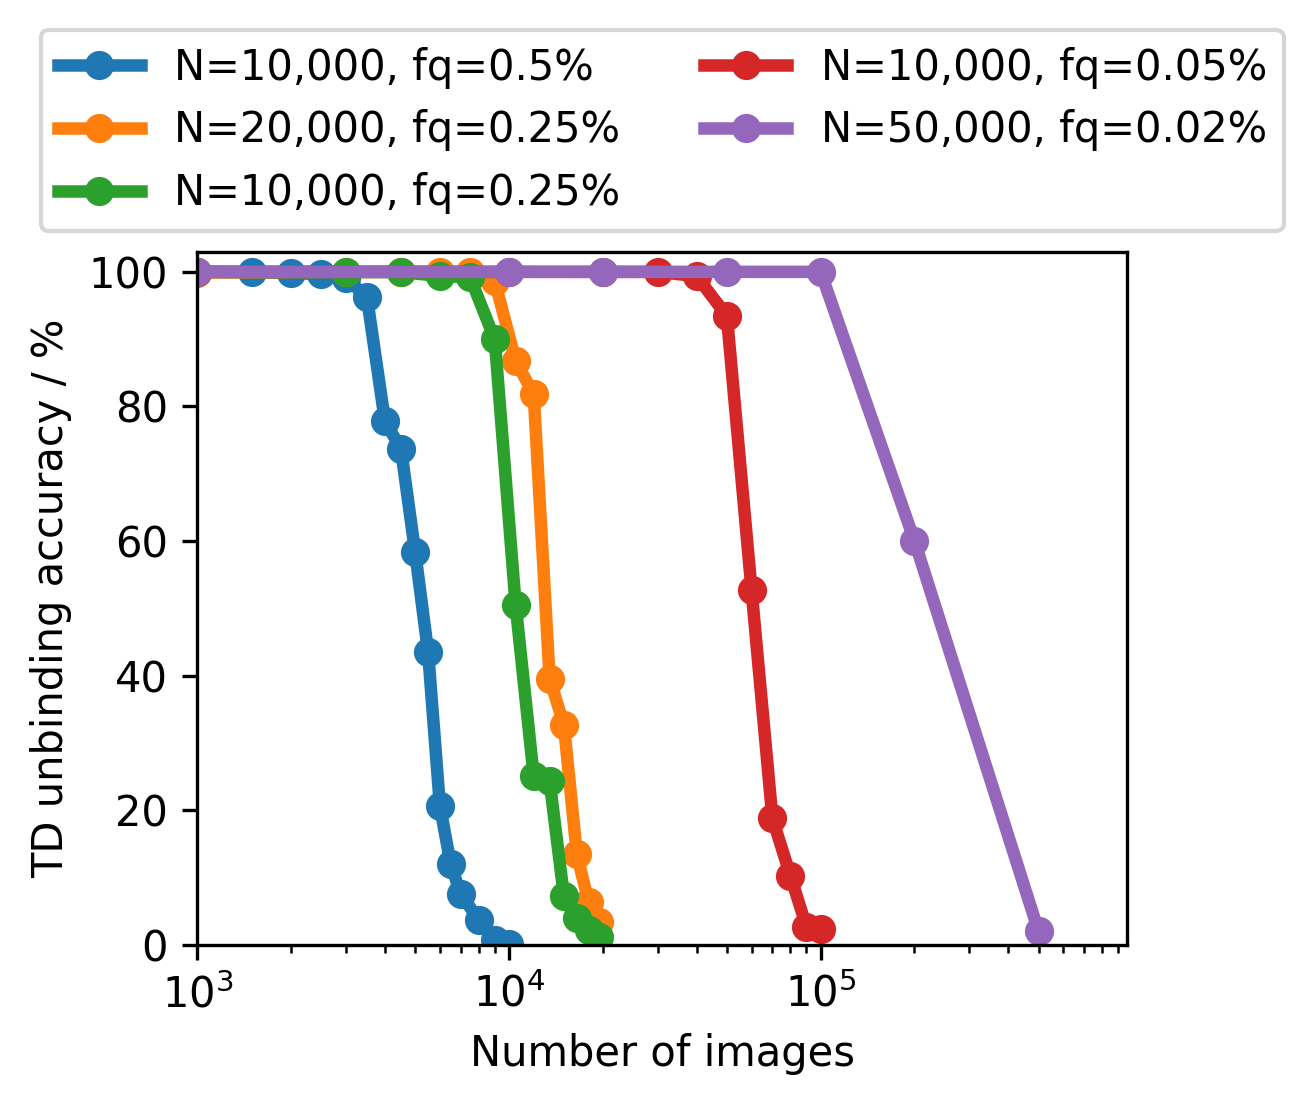

In [181]:
plt.figure(figsize=(4,3), dpi=300)
plt.plot(x_10000_0_005,
         np.array(all_correct_10000_0_005)*100,marker='o',lw=3,label='N=10,000, fq=0.5%')
plt.plot(x_20000_0_0025[::3],
         np.array(all_correct_20000_0_0025[::3])*100,marker='o',lw=3,label='N=20,000, fq=0.25%')
plt.plot(x_10000_0_0025[::3],
         np.array(all_correct_10000_0_0025[::3])*100,marker='o',lw=3,label='N=10,000, fq=0.25%')
plt.plot(x_10000_0_0005,np.array(all_correct_10000_0_0005)*100,marker='o',lw=3,label='N=10,000, fq=0.05%')
plt.plot(x_50000_0_0002,np.array(all_correct_50000_0_0002)*100,marker='o',lw=3,label='N=50,000, fq=0.02%')


plt.xscale('log')
plt.xlim(1000)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
plt.xlabel('Number of images')
plt.ylabel('TD unbinding accuracy / %')
plt.ylim(0.,103)

(0.0, 103.0)

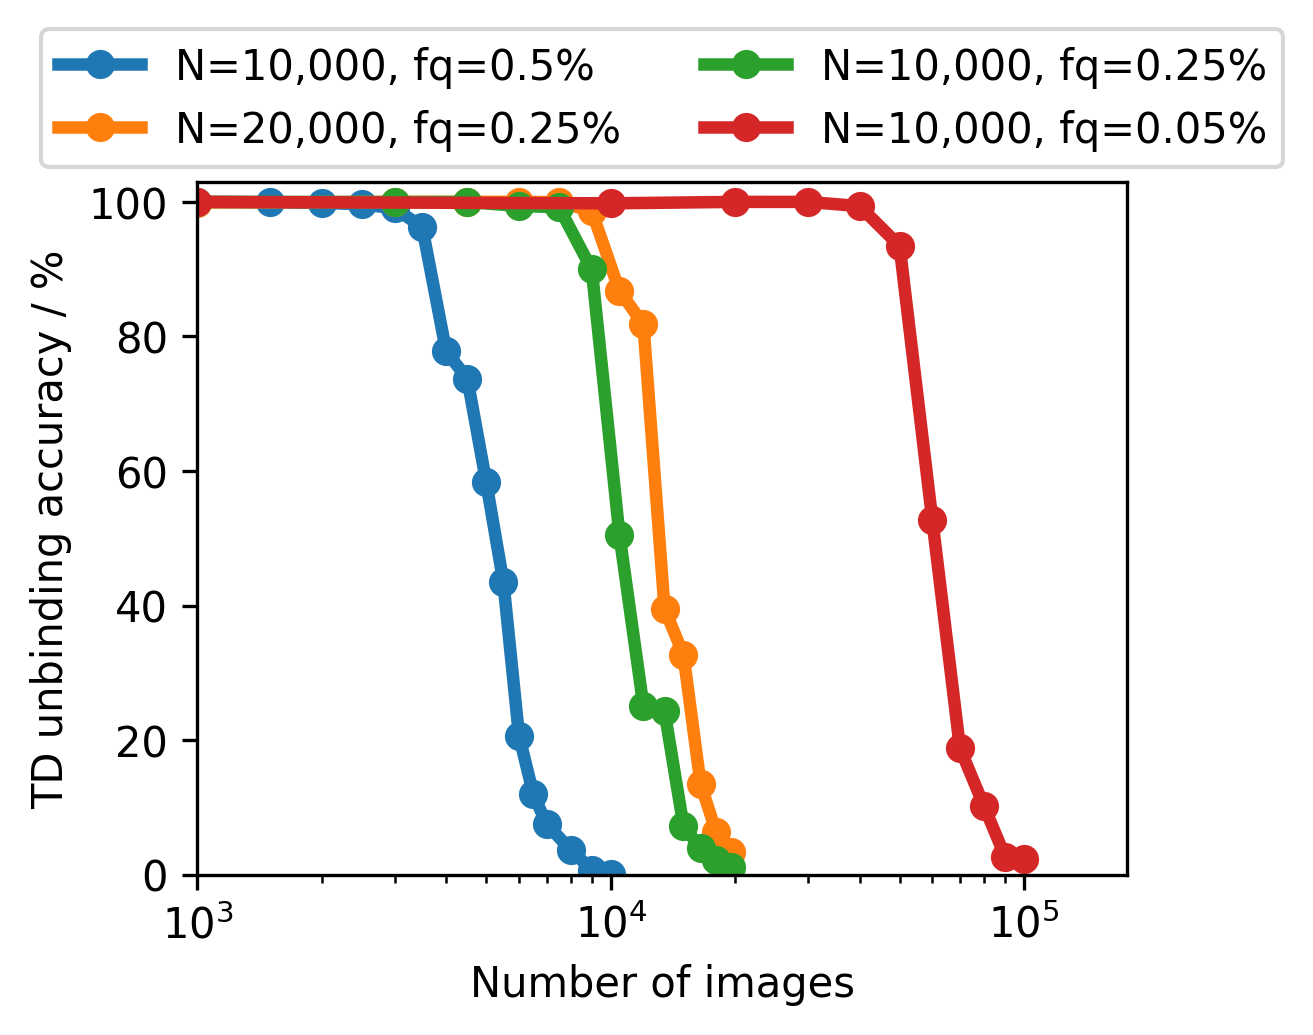

In [140]:
plt.figure(figsize=(4,3), dpi=300)
plt.plot(x_10000_0_005,
         np.array(all_correct_10000_0_005)*100,marker='o',lw=3,label='N=10,000, fq=0.5%')
plt.plot(x_20000_0_0025[::3],
         np.array(all_correct_20000_0_0025[::3])*100,marker='o',lw=3,label='N=20,000, fq=0.25%')
plt.plot(x_10000_0_0025[::3],
         np.array(all_correct_10000_0_0025[::3])*100,marker='o',lw=3,label='N=10,000, fq=0.25%')
plt.plot(x_10000_0_0005,np.array(all_correct)*100,marker='o',lw=3,label='N=10,000, fq=0.05%')
plt.xscale('log')
plt.xlim(1000)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
plt.xlabel('Number of images')
plt.ylabel('TD unbinding accuracy / %')
plt.ylim(0.,103)

In [144]:
from tqdm.notebook import tqdm

def wta_decode_full(reconstruct):
    decoded = np.zeros_like(reconstruct)
    for part in range(3):  # Three letters
        base = part * input_size

        # Decode letter
        i = np.argmax(reconstruct[base : base + n_letters])
        decoded[base + i] = 1

        # Decode color
        offset = base + n_letters
        i = np.argmax(reconstruct[offset : offset + n_colors])
        decoded[offset + i] = 1

        # Decode x position
        offset += n_colors
        i = np.argmax(reconstruct[offset : offset + img_size])
        decoded[offset + i] = 1

        # Decode y position
        offset += img_size
        i = np.argmax(reconstruct[offset : offset + img_size])
        decoded[offset + i] = 1

    return decoded

from tqdm.notebook import tqdm

def wta_decode_full(reconstruct):
    decoded = np.zeros_like(reconstruct)
    for part in range(3):  # Three letters
        base = part * input_size

        # Decode letter
        i = np.argmax(reconstruct[base : base + n_letters])
        decoded[base + i] = 1

        # Decode color
        offset = base + n_letters
        i = np.argmax(reconstruct[offset : offset + n_colors])
        decoded[offset + i] = 1

        # Decode x position
        offset += n_colors
        i = np.argmax(reconstruct[offset : offset + img_size])
        decoded[offset + i] = 1

        # Decode y position
        offset += img_size
        i = np.argmax(reconstruct[offset : offset + img_size])
        decoded[offset + i] = 1

    return decoded


n_letters = len(letters)
n_colors = len(color_names)
img_size = 64

# Define pre-synaptic representation size
input_size = (n_letters + n_colors + img_size * 2)  # 26 + 7 + 64 + 64 = 161

# Initialize 10,000 post-synaptic neurons with zero weights
all_res = []
all_correct = []
np.arange(2000,20000,500).tolist()
x_range = [1,10,100,200,500,1000,2000,5000,10000,20000,50000,100000]# + np.arange(1000,3001,1000).tolist()
np.save('BU_x_range_50000_0_0002',x_range)

for sample_size in x_range:
    n_post = 50000
    p=0.0002
    W_ff = np.zeros((n_post, input_size*3))
    W_fb = np.zeros((input_size*3, n_post))

    # Training
    all_data = []
    for i in tqdm(range(sample_size), desc='training'):
        letters_info = [sample_letter() for _ in range(3)]
        all_data += [letters_info]
        full_input = np.concatenate([
            encode_letter(letter_idx, color_idx, x, y)
            for letter_idx, color_idx, x, y in letters_info
        ])

        pre_active = full_input == 1
        selected_neurons = (np.random.rand(n_post)<=p)#  np.random.choice(n_post, size=int(n_post*p), replace=True)
        weights_ff = W_ff[selected_neurons]
        weights_fb = W_fb[:,selected_neurons]

        set_to_1 = np.logical_and(pre_active, weights_ff == 0)
        set_to_0 = np.logical_and(pre_active, weights_ff == 1)
        weights_ff[set_to_1] = 1
        weights_ff[set_to_0] = 0
        W_ff[selected_neurons] = weights_ff

        weights_fb[set_to_1.T] = 1
        W_fb[:,selected_neurons] = weights_fb

    def encode_letter(letter_idx, color_idx, x, y):
        
        vec = np.zeros(input_size)
        if letter_idx!=None:
            vec[letter_idx] = 1  # one-hot letter
        if color_idx!=None:
            vec[n_letters + color_idx] = 1  # one-hot color
        if x!=None:
            vec[n_letters + n_colors + x] = 1  # x position
        if y!=None:
            vec[n_letters + n_colors + img_size + y] = 1  # y position
        return vec
    # Inference:

    res = []
    for data in tqdm(all_data, desc = 'testing'):
        for rank, (letter_idx, color_idx, x, y) in enumerate(data):
            if rank == 0:
                letter_code = encode_letter(letter_idx, None, x, y)
            full_input_cue = np.concatenate([letter_code, np.zeros(input_size),np.zeros(input_size)])
            break

        full_input = np.concatenate([
            encode_letter(letter_idx, color_idx, x, y)
            for letter_idx, color_idx, x, y in data
        ])
        target = full_input>0
        reconstruct = W_fb@(((W_ff@full_input_cue)>2).astype('float'))
        reconstruct_wta = wta_decode_full(reconstruct)

        res += [np.sum(target==reconstruct_wta)/len(target)]
    print(np.mean(res), ((np.array(res)==1).sum()/len(res)))
    all_res += [np.mean(res)]
    all_correct += [((np.array(res)==1).sum()/len(res))]
    np.save('BU_all_correct_50000_0_0002',all_correct)
        
    

n_letters = len(letters)
n_colors = len(color_names)
img_size = 64

# Define pre-synaptic representation size
input_size = (n_letters + n_colors + img_size * 2)  # 26 + 7 + 64 + 64 = 161

# Initialize 10,000 post-synaptic neurons with zero weights
all_res = []
all_correct = []
np.arange(2000,20000,500).tolist()
x_range = [1,10,100,200,500,1000,2000,5000,10000,20000,50000,100000]# + np.arange(1000,3001,1000).tolist()
np.save('BU_x_range_50000_0_0002',x_range)

for sample_size in x_range:
    n_post = 50000
    p=0.0002
    W_ff = np.zeros((n_post, input_size*3))
    W_fb = np.zeros((input_size*3, n_post))

    # Training
    all_data = []
    for i in tqdm(range(sample_size), desc='training'):
        letters_info = [sample_letter() for _ in range(3)]
        all_data += [letters_info]
        full_input = np.concatenate([
            encode_letter(letter_idx, color_idx, x, y)
            for letter_idx, color_idx, x, y in letters_info
        ])

        pre_active = full_input == 1
        selected_neurons = (np.random.rand(n_post)<=p)#  np.random.choice(n_post, size=int(n_post*p), replace=True)
        weights_ff = W_ff[selected_neurons]
        weights_fb = W_fb[:,selected_neurons]

        set_to_1 = np.logical_and(pre_active, weights_ff == 0)
        set_to_0 = np.logical_and(pre_active, weights_ff == 1)
        weights_ff[set_to_1] = 1
        weights_ff[set_to_0] = 0
        W_ff[selected_neurons] = weights_ff

        weights_fb[set_to_1.T] = 1
        W_fb[:,selected_neurons] = weights_fb

    def encode_letter(letter_idx, color_idx, x, y):
        
        vec = np.zeros(input_size)
        if letter_idx!=None:
            vec[letter_idx] = 1  # one-hot letter
        if color_idx!=None:
            vec[n_letters + color_idx] = 1  # one-hot color
        if x!=None:
            vec[n_letters + n_colors + x] = 1  # x position
        if y!=None:
            vec[n_letters + n_colors + img_size + y] = 1  # y position
        return vec
    # Inference:

    res = []
    for data in tqdm(all_data, desc = 'testing'):
        for rank, (letter_idx, color_idx, x, y) in enumerate(data):
            if rank == 0:
                letter_code = encode_letter(letter_idx, None, x, y)
            full_input_cue = np.concatenate([letter_code, np.zeros(input_size),np.zeros(input_size)])
            break

        full_input = np.concatenate([
            encode_letter(letter_idx, color_idx, x, y)
            for letter_idx, color_idx, x, y in data
        ])
        target = full_input>0
        reconstruct = W_fb@(((W_ff@full_input_cue)>2).astype('float'))
        reconstruct_wta = wta_decode_full(reconstruct)

        res += [np.sum(target==reconstruct_wta)/len(target)]
    print(np.mean(res), ((np.array(res)==1).sum()/len(res)))
    all_res += [np.mean(res)]
    all_correct += [((np.array(res)==1).sum()/len(res))]
    np.save('BU_all_correct_50000_0_0002',all_correct)
        
    


training:   0%|          | 0/1 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/10 [00:00<?, ?it/s]

testing:   0%|          | 0/10 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/100 [00:00<?, ?it/s]

testing:   0%|          | 0/100 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/200 [00:00<?, ?it/s]

testing:   0%|          | 0/200 [00:00<?, ?it/s]

0.9998136645962734 0.995


training:   0%|          | 0/500 [00:00<?, ?it/s]

testing:   0%|          | 0/500 [00:00<?, ?it/s]

0.9999254658385094 0.998


training:   0%|          | 0/1000 [00:00<?, ?it/s]

testing:   0%|          | 0/1000 [00:00<?, ?it/s]

0.99975983436853 0.992


training:   0%|          | 0/2000 [00:00<?, ?it/s]

testing:   0%|          | 0/2000 [00:00<?, ?it/s]

0.9996708074534162 0.99


training:   0%|          | 0/5000 [00:00<?, ?it/s]

testing:   0%|          | 0/5000 [00:00<?, ?it/s]

0.9991072463768116 0.96


training:   0%|          | 0/10000 [00:00<?, ?it/s]

testing:   0%|          | 0/10000 [00:00<?, ?it/s]

0.9971755693581781 0.7715


training:   0%|          | 0/20000 [00:00<?, ?it/s]

testing:   0%|          | 0/20000 [00:00<?, ?it/s]

0.9849101449275363 0.08705


training:   0%|          | 0/50000 [00:00<?, ?it/s]

testing:   0%|          | 0/50000 [00:00<?, ?it/s]

0.9669006211180124 0.0


training:   0%|          | 0/100000 [00:00<?, ?it/s]

testing:   0%|          | 0/100000 [00:00<?, ?it/s]

0.9653676604554865 0.0


(0.0, 103.5)

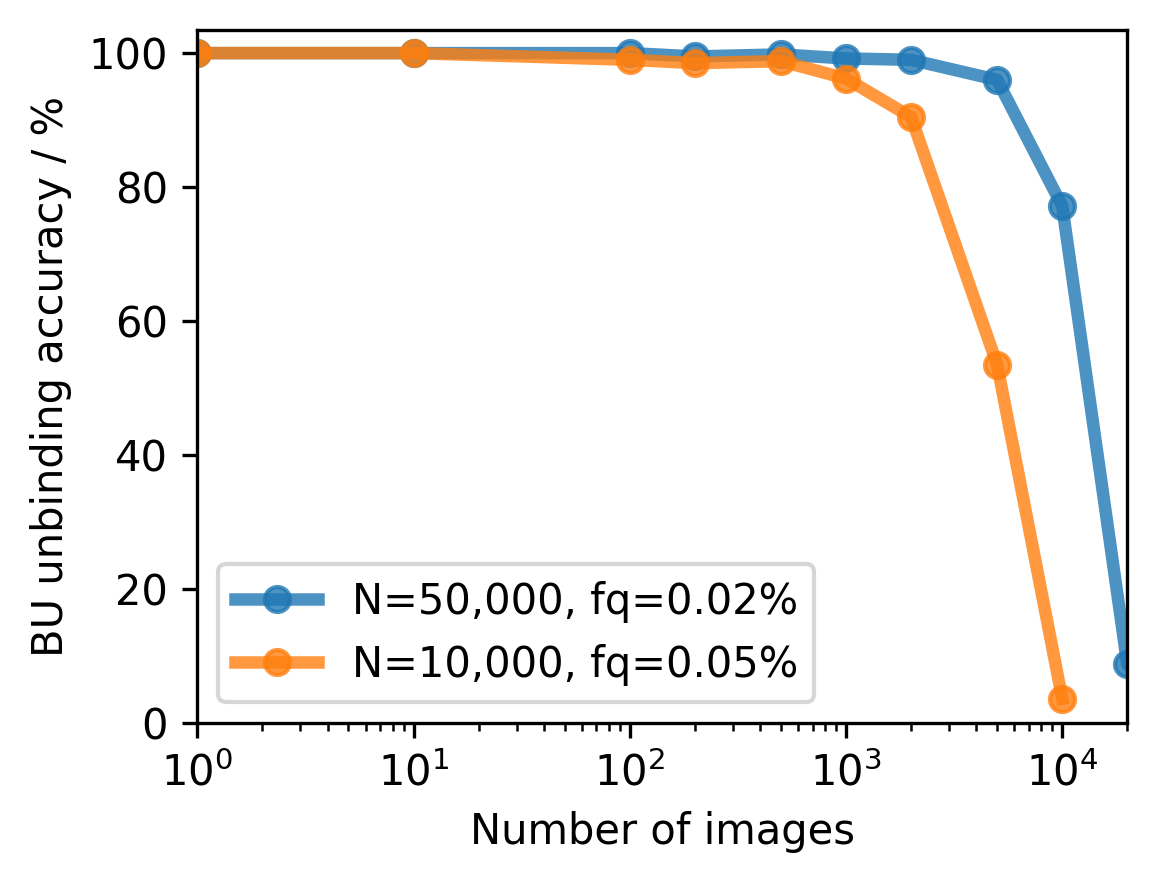

In [189]:
plt.figure(figsize=(4,3), dpi=300)
x_10000_0_005 = np.load('BU_x_range_10000_0_005.npy')
all_correct_10000_0_005 = np.load('BU_all_correct_10000_0_005.npy')
x_10000_0_0025 = np.load('BU_x_range_10000_0_0025.npy')
all_correct_10000_0_0025 = np.load('BU_all_correct_10000_0_0025.npy')
x_20000_0_0025 = np.load('BU_x_range_20000_0_0025.npy')
all_correct_20000_0_0025 = np.load('BU_all_correct_20000_0_0025.npy')
x_10000_0_0005 = np.load('BU_x_range_10000_0_0005.npy')
all_correct_10000_0_0005 = np.load('BU_all_correct_10000_0_0005.npy')
x_50000_0_0002 = np.load('BU_x_range_50000_0_0002.npy')
all_correct_50000_0_0002 = np.load('BU_all_correct_50000_0_0002.npy')
plt.plot(x_50000_0_0002,np.array(all_correct_50000_0_0002)*100,marker='o',lw=3,label='N=50,000, fq=0.02%',alpha=.8)
plt.plot(x_10000_0_0005,np.array(all_correct_10000_0_0005)*100,marker='o',lw=3,label='N=10,000, fq=0.05%',alpha=.8)

# plt.plot(x_10000_0_0025,
#          np.array(all_correct_10000_0_0025)*100,marker='o',lw=3,label='N=10,000, fq=0.25%',alpha=.8)
# plt.plot(x_20000_0_0025,
#          np.array(all_correct_20000_0_0025)*100,marker='o',lw=3,label='N=20,000, fq=0.25%',alpha=.8)

# plt.plot(x_10000_0_005,
#          np.array(all_correct_10000_0_005)*100,marker='o',lw=3,label='N=10,000, fq=0.5%',alpha=.8)
# plt.plot([1,300000],[95.2763904,95.2763904],'--',c='black')

plt.xscale('log')
plt.xlim(1,20000)
plt.legend()
plt.xlabel('Number of images')
plt.ylabel('BU unbinding accuracy / %')

plt.ylim(0.,103.5)

In [200]:
from collections import defaultdict

def sample_images_no_pair_reuse(n_images, n_letters, n_colors, img_size, rng=None):
    """
    Each image contains 3 distinct tokens, token = (letter, color).
    Across the whole dataset, no unordered pair of tokens may repeat.
    Greedy 'sample-from-remaining' approach: at each step sample a triangle
    (t1,t2,t3) in the current graph of unused pairs, then remove its 3 edges.
    """
    if rng is None:
        rng = random

    U = n_letters * n_colors
    # Helper maps
    def tok_to_lc(tok):
        return tok // n_colors, tok % n_colors

    tokens = list(range(U))
    # Graph of unused pairs as adjacency sets
    nbrs = [set(tokens) for _ in range(U)]
    for i in range(U):
        nbrs[i].remove(i)  # no self-pair

    max_pairs = U * (U - 1) // 2
    max_images = max_pairs // 3
    print(max_images)
    if n_images > max_images:
        raise ValueError(
            f"Requested {n_images} images but maximum without pair collisions is {max_images}."
        )

    dataset = []
    attempts = 0

    def remove_edge(a, b):
        # remove unordered edge {a,b}
        if b in nbrs[a]:
            nbrs[a].remove(b)
        if a in nbrs[b]:
            nbrs[b].remove(a)

    while len(dataset) < n_images:
        attempts += 1
        if attempts > 10_000_000:
            raise RuntimeError("Too many attempts; remaining graph is too sparse to continue.")

        # pick a promising center token with degree >= 2
        centers = [t for t in tokens if len(nbrs[t]) >= 2]
        if not centers:
            raise RuntimeError("No remaining triangles in the graph; cannot reach requested size.")
        t1 = rng.choice(centers)

        # pick a first neighbor
        if len(nbrs[t1]) < 2:
            continue
        t2 = rng.choice(tuple(nbrs[t1]))

        # pick a third token that closes a triangle: in intersection of neighbors
        common = nbrs[t1].intersection(nbrs[t2])
        if not common:
            # try another t2 quickly
            # (small retry to reduce global attempts)
            tried = 0
            success = False
            for t2_try in rng.sample(tuple(nbrs[t1]), min(8, len(nbrs[t1]))):
                inter = nbrs[t1].intersection(nbrs[t2_try])
                if inter:
                    t2 = t2_try
                    common = inter
                    success = True
                    break
                tried += 1
            if not success:
                continue

        t3 = rng.choice(tuple(common))

        # We found a triangle (t1,t2,t3). Remove its 3 edges (pairs) from the remaining pool.
        remove_edge(t1, t2)
        remove_edge(t1, t3)
        remove_edge(t2, t3)

        # Build the image with random positions
        letters_info = []
        for tok in (t1, t2, t3):
            l, c = tok_to_lc(tok)
            x = rng.randint(0, img_size - 1)
            y = rng.randint(0, img_size - 1)
            letters_info.append((l, c, x, y))
        dataset.append(letters_info)

    return dataset

In [201]:
sample_images_no_pair_reuse(
        n_images=10,
        n_letters=n_letters,
        n_colors=n_colors,
        img_size=img_size,
    )

5490


[[(21, 2, 38, 44), (24, 2, 22, 61), (24, 1, 9, 33)],
 [(19, 0, 1, 26), (12, 0, 35, 19), (14, 3, 8, 51)],
 [(5, 6, 12, 6), (9, 6, 50, 62), (8, 5, 48, 42)],
 [(15, 6, 56, 18), (20, 0, 35, 16), (14, 2, 46, 52)],
 [(5, 3, 14, 17), (7, 3, 10, 52), (18, 4, 32, 29)],
 [(16, 1, 10, 51), (18, 4, 21, 4), (17, 5, 4, 51)],
 [(23, 6, 5, 9), (2, 3, 16, 19), (2, 4, 5, 32)],
 [(16, 1, 6, 19), (0, 2, 1, 34), (2, 3, 49, 39)],
 [(10, 2, 7, 24), (23, 1, 57, 5), (10, 0, 63, 29)],
 [(6, 0, 14, 48), (10, 3, 63, 24), (8, 3, 18, 0)]]

In [164]:
from tqdm.notebook import tqdm

def wta_decode_full(reconstruct):
    decoded = np.zeros_like(reconstruct)
    for part in range(3):  # Three letters
        base = part * input_size

        # Decode letter
        i = np.argmax(reconstruct[base : base + n_letters])
        decoded[base + i] = 1

        # Decode color
        offset = base + n_letters
        i = np.argmax(reconstruct[offset : offset + n_colors])
        decoded[offset + i] = 1

        # Decode x position
        offset += n_colors
        i = np.argmax(reconstruct[offset : offset + img_size])
        decoded[offset + i] = 1

        # Decode y position
        offset += img_size
        i = np.argmax(reconstruct[offset : offset + img_size])
        decoded[offset + i] = 1

    return decoded


n_letters = len(letters)
n_colors = len(color_names)
img_size = 64

# Define pre-synaptic representation size
input_size = (n_letters + n_colors + img_size * 2)  # 26 + 7 + 64 + 64 = 161

# Initialize 10,000 post-synaptic neurons with zero weights
all_res = []
all_correct = []
np.arange(2000,20000,500).tolist()
x_range = [1,10,100,200,500,1000,2000,5000,5490]#,5000,10000,20000,30000]# + np.arange(1000,3001,1000).tolist()
np.save('BU_2_x_range_50000_0_0002',x_range)
def encode_letter(letter_idx, color_idx, x, y):
    vec = np.zeros(input_size)
    if letter_idx!=None:
        vec[letter_idx] = 1  # one-hot letter
    if color_idx!=None:
        vec[n_letters + color_idx] = 1  # one-hot color
    if x!=None:
        vec[n_letters + n_colors + x] = 1  # x position
    if y!=None:
        vec[n_letters + n_colors + img_size + y] = 1  # y position
    return vec
    
for sample_size in x_range:
    n_post = 50000
    p=0.0002
    W_ff = np.zeros((n_post, input_size*3))
    W_fb = np.zeros((input_size*3, n_post))
    all_data = sample_images_no_pair_reuse(
        n_images=sample_size,
        n_letters=n_letters,
        n_colors=n_colors,
        img_size=img_size,
    )

    # Training
    for letters_info in tqdm(all_data, desc="training"):
        # build full input from the 3 letters in this image
        full_input = np.concatenate([
            encode_letter(letter_idx, color_idx, x, y)
            for (letter_idx, color_idx, x, y) in letters_info
        ])


        pre_active = full_input == 1
        selected_neurons = (np.random.rand(n_post)<=p)#  np.random.choice(n_post, size=int(n_post*p), replace=True)
        weights_ff = W_ff[selected_neurons]
        weights_fb = W_fb[:,selected_neurons]

        set_to_1 = np.logical_and(pre_active, weights_ff == 0)
        set_to_0 = np.logical_and(pre_active, weights_ff == 1)
        weights_ff[set_to_1] = 1
        weights_ff[set_to_0] = 0
        W_ff[selected_neurons] = weights_ff

        weights_fb[set_to_1.T] = 1
        W_fb[:,selected_neurons] = weights_fb

    
    # Inference:

    res = []
    for data in tqdm(all_data, desc = 'testing'):
        for rank, (letter_idx, color_idx, x, y) in enumerate(data):
            if rank == 0:
                letter_code0 = encode_letter(letter_idx, color_idx, None, None)
            elif rank == 1:
                letter_code1 = encode_letter(letter_idx, color_idx, None, None)
                
        full_input_cue = np.concatenate([letter_code0, letter_code1, np.zeros(input_size)])
            

        full_input = np.concatenate([
            encode_letter(letter_idx, color_idx, x, y)
            for letter_idx, color_idx, x, y in data
        ])
        target = full_input>0
        reconstruct = W_fb@(((W_ff@full_input_cue)>3).astype('float'))
        reconstruct_wta = wta_decode_full(reconstruct)

        res += [np.sum(target==reconstruct_wta)/len(target)]
    print(np.mean(res), ((np.array(res)==1).sum()/len(res)))
    all_res += [np.mean(res)]
    all_correct += [((np.array(res)==1).sum()/len(res))]
    np.save('BU_2_all_correct_50000_0_0002',all_correct)
        
    


training:   0%|          | 0/1 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/10 [00:00<?, ?it/s]

testing:   0%|          | 0/10 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/100 [00:00<?, ?it/s]

testing:   0%|          | 0/100 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/200 [00:00<?, ?it/s]

testing:   0%|          | 0/200 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/500 [00:00<?, ?it/s]

testing:   0%|          | 0/500 [00:00<?, ?it/s]

1.0 1.0


training:   0%|          | 0/1000 [00:00<?, ?it/s]

testing:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9999337474120084 0.998


training:   0%|          | 0/2000 [00:00<?, ?it/s]

testing:   0%|          | 0/2000 [00:00<?, ?it/s]

0.9999585921325052 0.9965


training:   0%|          | 0/5000 [00:00<?, ?it/s]

testing:   0%|          | 0/5000 [00:00<?, ?it/s]

0.9985474120082816 0.8598


ValueError: Requested 10000 images but maximum without pair collisions is 5490.

(0.0, 103.5)

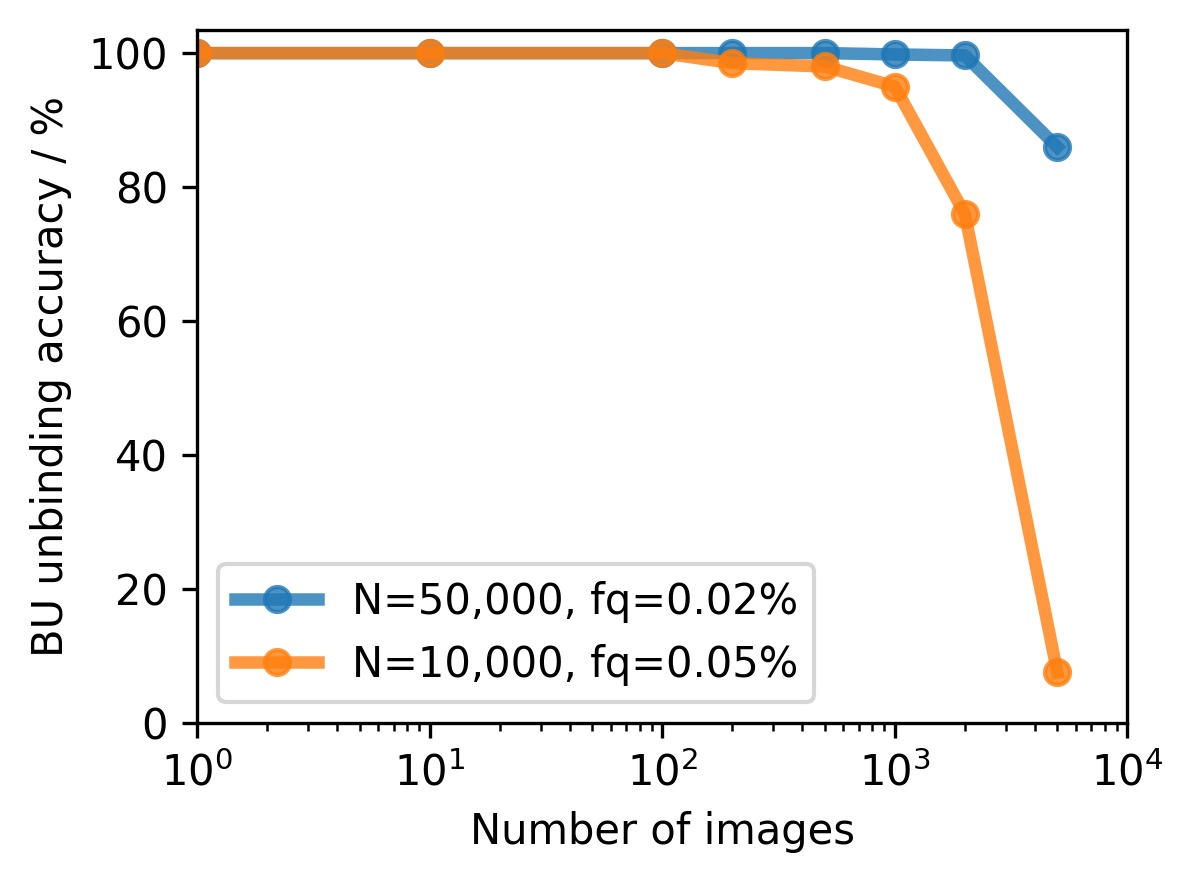

In [192]:
plt.figure(figsize=(4,3), dpi=300)
x_10000_0_005 = np.load('BU_2_x_range_10000_0_005.npy')
all_correct_10000_0_005 = np.load('BU_2_all_correct_10000_0_005.npy')
x_10000_0_0025 = np.load('BU_2_x_range_10000_0_0025.npy')
all_correct_10000_0_0025 = np.load('BU_2_all_correct_10000_0_0025.npy')
x_20000_0_0025 = np.load('BU_2_x_range_20000_0_0025.npy')
all_correct_20000_0_0025 = np.load('BU_2_all_correct_20000_0_0025.npy')
x_10000_0_0005 = np.load('BU_2_x_range_10000_0_0005.npy')
all_correct_10000_0_0005 = np.load('BU_2_all_correct_10000_0_0005.npy')
x_50000_0_0002 = np.load('BU_2_x_range_50000_0_0002.npy')
all_correct_50000_0_0002 = np.load('BU_2_all_correct_50000_0_0002.npy')
plt.plot(x_50000_0_0002[:-1],np.array(all_correct_50000_0_0002)*100,marker='o',lw=3,label='N=50,000, fq=0.02%',alpha=.8)
plt.plot(x_10000_0_0005,np.array(all_correct_10000_0_0005)*100,marker='o',lw=3,label='N=10,000, fq=0.05%',alpha=.8)

# plt.plot(x_10000_0_0025,
#          np.array(all_correct_10000_0_0025)*100,marker='o',lw=3,label='N=10,000, fq=0.25%',alpha=.8)
# plt.plot(x_20000_0_0025,
#          np.array(all_correct_20000_0_0025)*100,marker='o',lw=3,label='N=20,000, fq=0.25%',alpha=.8)

# plt.plot(x_10000_0_005,
#          np.array(all_correct_10000_0_005)*100,marker='o',lw=3,label='N=10,000, fq=0.5%',alpha=.8)
# plt.plot([1,300000],[95.2763904,95.2763904],'--',c='black')

plt.xscale('log')
plt.xlim(1,10000)
plt.legend()#loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
plt.xlabel('Number of images')
plt.ylabel('BU unbinding accuracy / %')

plt.ylim(0.,103.5)

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D  # only for 3D plotting

# --- your fixed settings --------------------------------
n_post     = 10_000
img_size   = 64
# assume 'letters' and 'color_names' are already defined lists
n_letters  = len(letters)
n_colors   = len(color_names)
input_size = n_letters + n_colors + img_size*2


    

# --- helper functions -----------------------------------
def checkpoint(results, fname='xyz_results.csv'):
    df = pd.DataFrame(results, columns=['sample_size','p','all_correct'])
    df.to_csv(fname, index=False)
    
def encode_letter(letter_idx, color_idx, x, y):
    vec = np.zeros(input_size)
    vec[letter_idx] = 1
    vec[n_letters + color_idx] = 1
    vec[n_letters + n_colors + x] = 1
    vec[n_letters + n_colors + img_size + y] = 1
    return vec

def evaluate_all_correct(sample_size, p):
    """
    Train on `sample_size` examples with sparsity p, then
    test on the same examples and return
      all_correct = fraction of trials where res == 1
    """
    # init weights
    W_ff = np.zeros((n_post, input_size*3))
    W_fb = np.zeros((input_size*3, n_post))
    # collect data
    all_data = []
    for _ in range(sample_size):
        letters_info = [sample_letter() for _ in range(3)]
        all_data += [letters_info]
        full_input = np.concatenate([
            encode_letter(letter_idx, color_idx, x, y)
            for letter_idx, color_idx, x, y in letters_info
        ])

        pre_active = full_input == 1
        selected_neurons = np.random.choice(n_post, size=int(n_post*p), replace=True)
        weights_ff = W_ff[selected_neurons]
        weights_fb = W_fb[:,selected_neurons]

        set_to_1 = np.logical_and(pre_active, weights_ff == 0)
        set_to_0 = np.logical_and(pre_active, weights_ff == 1)
        weights_ff[set_to_1] = 1
        weights_ff[set_to_0] = 0
        W_ff[selected_neurons] = weights_ff

        weights_fb[set_to_1.T] = 1
        W_fb[:,selected_neurons] = weights_fb

    # testing
    perfect = 0
    res = []
    for triplet in tqdm(all_data,desc='testing'):
        full_input = np.concatenate([
            encode_letter(letter_idx, color_idx, x, y)
            for letter_idx, color_idx, x, y in data
        ])
        target = full_input>0
        reconstruct = W_fb@(((W_ff@full_input)>5).astype('float'))
        reconstruct_wta = wta_decode_full(reconstruct)
        res += [np.sum(target==reconstruct_wta)/len(target)]

    print(((np.array(res)==1).sum()/len(res)))
    
    return ((np.array(res)==1).sum()/len(res))

def find_transition_for_p(p, lo_thresh=0.98, hi_thresh=0.02):
    # 1) coarse scan at powers of 10, but stop early
    coarse = np.array([1, 10, 100, 1_000, 10_000, 100_000, 1_000_000], dtype=int)
    metrics = []
    N_lo = N_hi = None

    for i, N in enumerate(coarse):
        m = evaluate_all_correct(N, p)
        metrics.append(m)

        # if we just fell below hi_thresh and the previous was above lo_thresh
        if m < hi_thresh and i > 0 and metrics[i-1] > lo_thresh:
            N_lo, N_hi = coarse[i-1], coarse[i]
            break
        # also, if we hit hi_thresh right away (unlikely), bail
        if m < hi_thresh and i == 0:
            N_lo, N_hi = coarse[0], coarse[1]
            break
    else:
        # never found a crossing — just use whatever we got
        return list(zip(coarse[:len(metrics)], metrics))

    # 2) fine‐sample that one interval and return
    fine = np.linspace(N_lo, N_hi, 10, dtype=int)
    fine_pts = [(N, evaluate_all_correct(N, p)) for N in fine]
    return fine_pts


# --- main sweep & live plot --------------------------------
# coarse magnitudes to test

coarse = np.array([1, 10, 100, 1_000, 10_000, 100_000, 1_000_000], dtype=int)
p_vals = [0.0001]#np.linspace(0.0001, 0.01, 100)[::-1]


results = []

for p in tqdm(p_vals, desc='Sweep over p'):
    # Coarse scan with early stopping
    metrics = []
    for N in tqdm(coarse, desc=f'  Coarse @ p={p:.4f}', leave=False):
        m = evaluate_all_correct(N, p)
        metrics.append((N, m))
        if m < 0.02 and len(metrics) > 1 and metrics[-2][1] > 0.98:
            break

    # Record either coarse or fine‐sampled data
    if not (metrics[-1][1] < 0.02 and metrics[0][1] > 0.98):
        results.extend(metrics)
    else:
        N_lo, _ = metrics[-2]
        N_hi, _ = metrics[-1]
        fine = np.linspace(N_lo, N_hi, 10, dtype=int)
        for N in tqdm(fine, desc=f'  Fine @ p={p:.4f}', leave=False):
            m = evaluate_all_correct(N, p)
            results.append((N, m, p))


plt.ioff()


Sweep over p:   0%|          | 0/1 [00:00<?, ?it/s]

  Coarse @ p=0.0001:   0%|          | 0/7 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

0.0


testing:   0%|          | 0/10 [00:00<?, ?it/s]

0.0


testing:   0%|          | 0/100 [00:00<?, ?it/s]

0.0


testing:   0%|          | 0/1000 [00:00<?, ?it/s]

0.0


testing:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [50]:
for r in results:
    print(r)
    break

(1000, 0.996, 0.01)


In [61]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# — load & filter —
if os.path.exists('xyz_results.csv'):
    df = pd.read_csv('xyz_results.csv')
else:
    df = pd.DataFrame(columns=['sample_size','p','all_correct'])

# extract arrays
X_all = df['sample_size'].to_numpy()
Y_all = df['all_correct'].to_numpy()
Z_all = df['p'].to_numpy()

mask = X_all > 0
X, Y, Z = X_all[mask], Y_all[mask], Z_all[mask]

# — build interactive mesh —
fig = go.Figure(
    data=go.Mesh3d(
        x=X,
        y=Y,
        z=Z,
        intensity=Z,            # color by Z
        colorscale='Viridis',
        opacity=0.9,
        showscale=True
    )
)

# — layout & log‐scale on x-axis —
fig.update_layout(
    scene = dict(
        xaxis = dict(title='Sample size', type='log'),
        yaxis = dict(title='p'),
        zaxis = dict(title='All correct'),
    ),
    width=800,
    height=600,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()


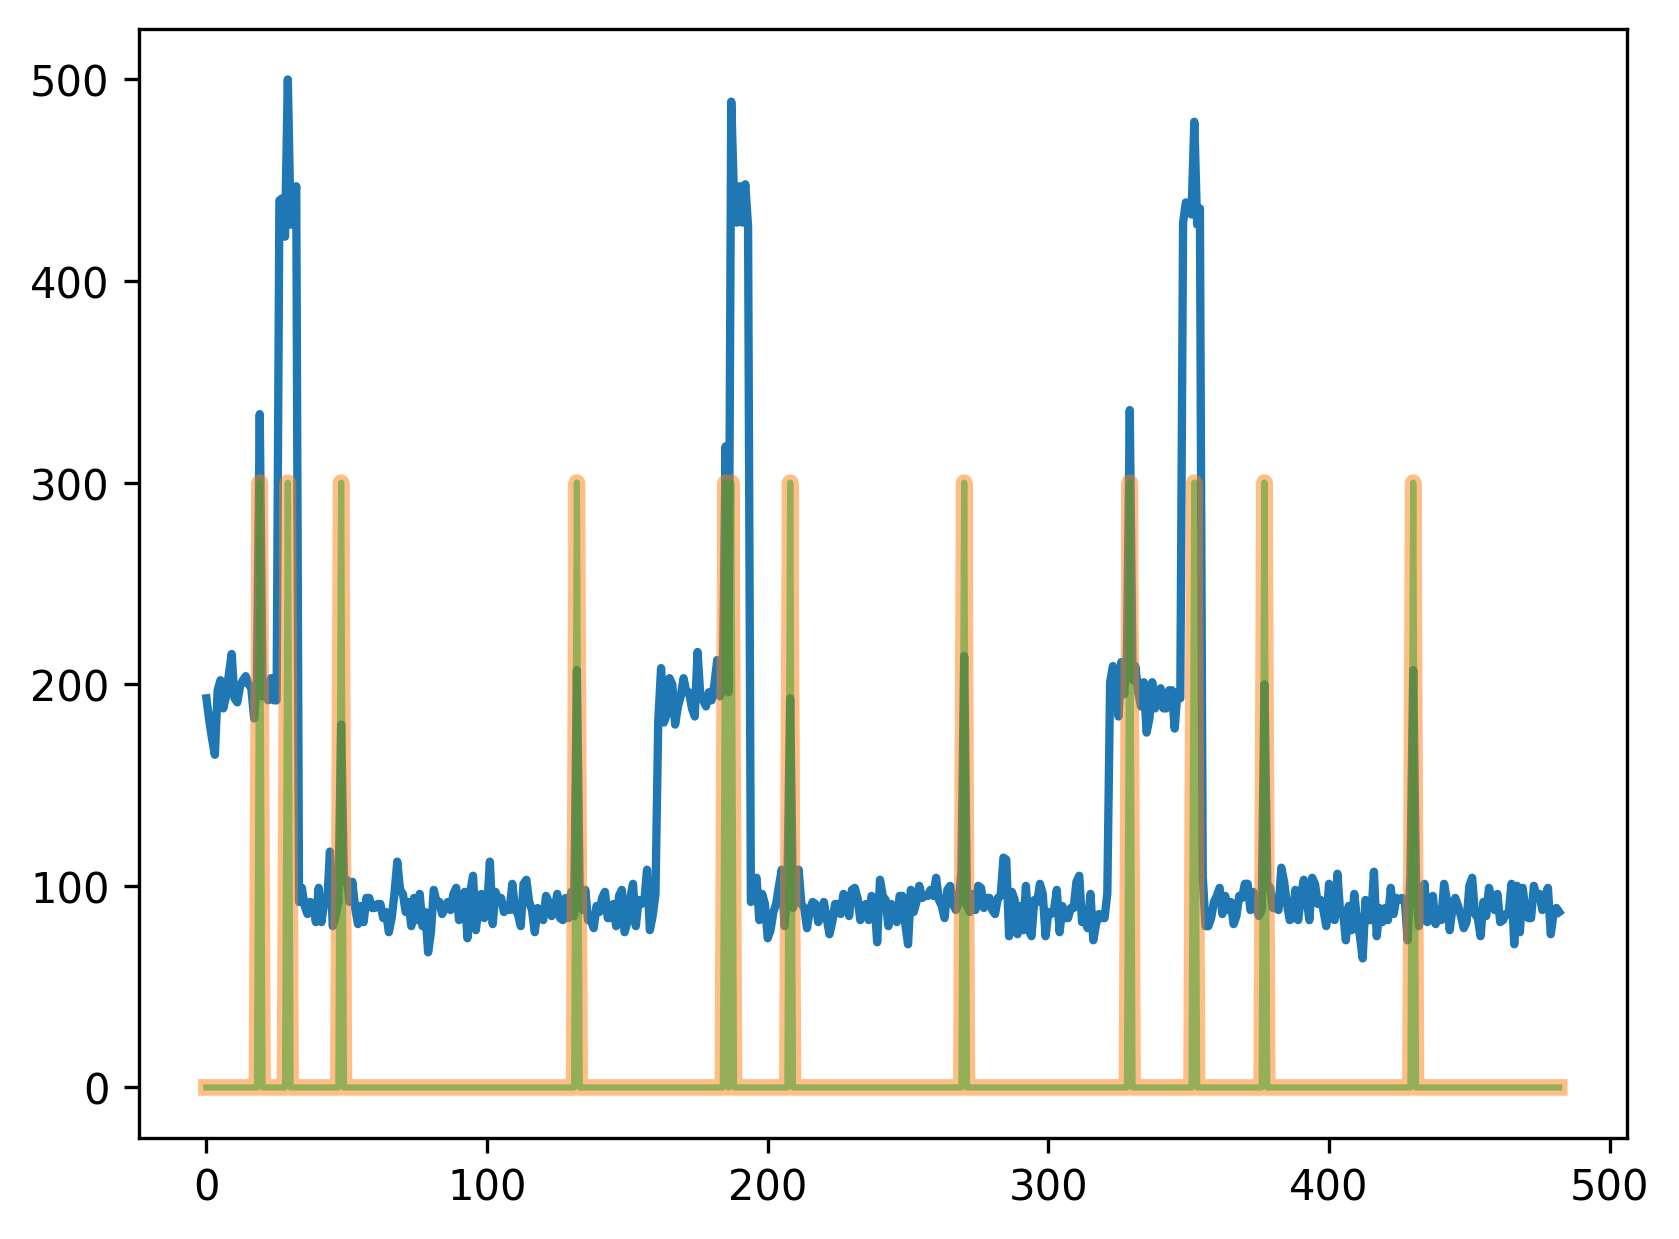

In [38]:
plt.figure(dpi=300)
plt.plot(W_fb@((W_ff@full_input)>5),lw=2)
plt.plot(300*reconstruct_wta,lw=4,alpha=.5)
plt.plot(300*target,alpha=.5)

In [24]:
target.astype('float')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

(0.0, 103.0)

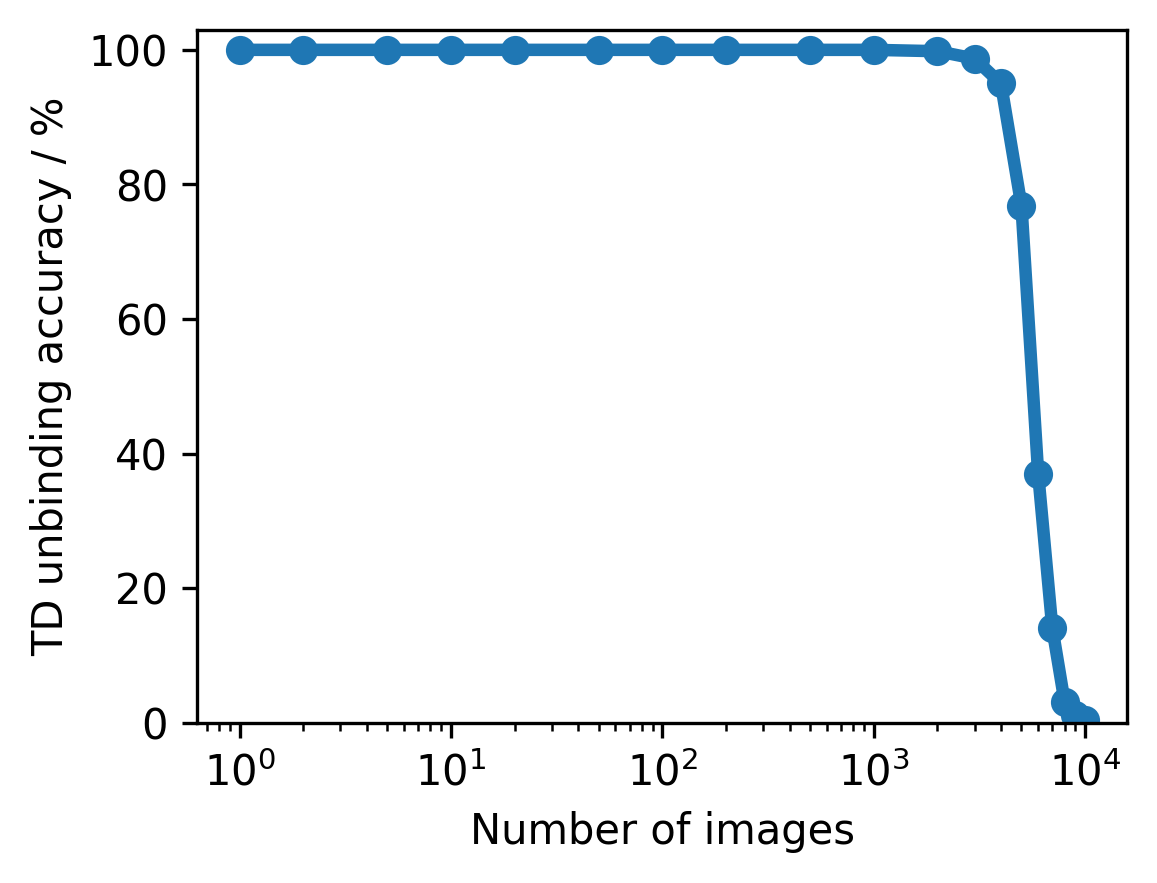

In [317]:
plt.figure(figsize=(4,3), dpi=300)
plt.plot([1,2,5,10,20,50,100,200,500,1000,2000,3000,4000,5000, 6000, 7000, 8000, 9000,10000],
         np.array(all_correct)*100,marker='o',lw=3)
plt.xscale('log')
plt.xlabel('Number of images')
plt.ylabel('TD unbinding accuracy / %')
plt.ylim(0.,103)

In [263]:
res

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9544513457556936,
 1.0,
 0.9503105590062112,
 0.9544513457556936,
 1.0,
 0.9544513457556936,
 0.9544513457556936,
 1.0,
 1.0,
 0.9503105590062112,
 1.0,
 0.9627329192546584,
 1.0,
 0.9503105590062112,
 0.9503105590062112,
 1.0,
 1.0,
 1.0,
 0.9544513457556936,
 0.9544513457556936,
 0.9503105590062112,
 0.9503105590062112,
 0.9503105590062112,
 1.0,
 1.0,
 1.0,
 0.9503105590062112,
 1.0,
 0.9627329192546584,
 0.9503105590062112,
 0.9503105590062112,
 1.0,
 1.0,
 0.9503105590062112,
 1.0,
 0.9544513457556936,
 1.0,
 0.9503105590062112,
 1.0,
 0.9503105590062112,
 1.0,
 1.0,
 0.9503105590062112,
 0.9503105590062112,
 1.0,
 0.9544513457556936,
 0.9503105590062112,
 1.0,
 0.9503105590062112,
 1.0,
 1.0,
 0.9503105590062112,
 0.9544513457556936,
 1.0,
 0.9503105590062112,
 1.0,
 1.0,
 0.9503105590062112,
 0.9544513457556936,
 1.0,
 1.0,
 1.0,
 0.9503105590062112,
 0.9503105590062112,
 0.9503105590062112,
 0.9585921325051759,
 0.9503105590062112,
 0.9503105590

In [161]:
import torch
from tqdm.notebook import tqdm

# Assuming these are already defined
n_letters = len(letters)
n_colors = len(color_names)
img_size = 64
input_size = (n_letters + n_colors + img_size * 2)  # 26 + 7 + 64 + 64 = 161

n_post = 10000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize weights on CUDA
W_ff = torch.zeros((n_post, input_size * 3), device=device)
W_fb = torch.zeros((input_size * 3, n_post), device=device)

# Training
all_data = []
for _ in tqdm(range(100), desc='training'):
    letters_info = [sample_letter() for _ in range(3)]
    all_data.append(letters_info)

    full_input_np = np.concatenate([
        encode_letter(letter_idx, color_idx, x, y)
        for letter_idx, color_idx, x, y in letters_info
    ])
    full_input = torch.tensor(full_input_np, dtype=torch.float32, device=device)

    pre_active = full_input == 1
    selected_neurons = torch.tensor(
        np.random.choice(n_post, size=50, replace=False),
        dtype=torch.long, device=device
    )

    weights_ff = W_ff[selected_neurons]
    weights_fb = W_fb[:, selected_neurons]

    set_to_1 = torch.logical_and(pre_active, weights_ff == 0)
    set_to_0 = torch.logical_and(pre_active, weights_ff == 1)

    weights_ff[set_to_1] = 1
    weights_ff[set_to_0] = 0
    W_ff[selected_neurons] = weights_ff

    set_to_1_fb = set_to_1.T  # Transpose for feedback weights
    weights_fb[set_to_1_fb] = 1
    W_fb[:, selected_neurons] = weights_fb

# Inference
res = []
for data in tqdm(all_data, desc='testing'):
    full_input_np = np.concatenate([
        encode_letter(letter_idx, color_idx, x, y)
        for letter_idx, color_idx, x, y in data
    ])
    full_input = torch.tensor(full_input_np, dtype=torch.float32, device=device)

    target = (full_input > 0)
    output = ((W_fb @ W_ff @ full_input))
    res.append((torch.sum((target == output))/len(target)).cpu().item())

print(res[-1])


training:   0%|          | 0/100 [00:00<?, ?it/s]

testing:   0%|          | 0/100 [00:00<?, ?it/s]

0.14699792861938477


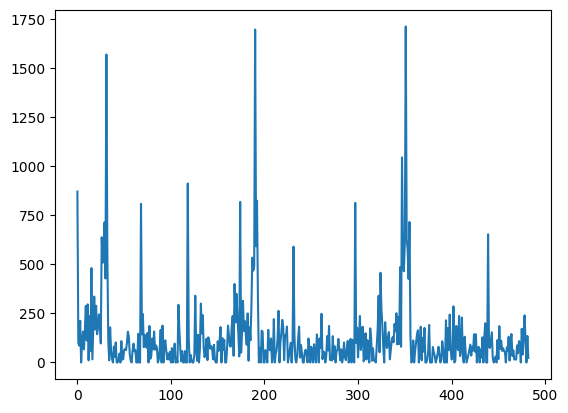

In [155]:
plt.plot((W_fb @ W_ff @ full_input).cpu())

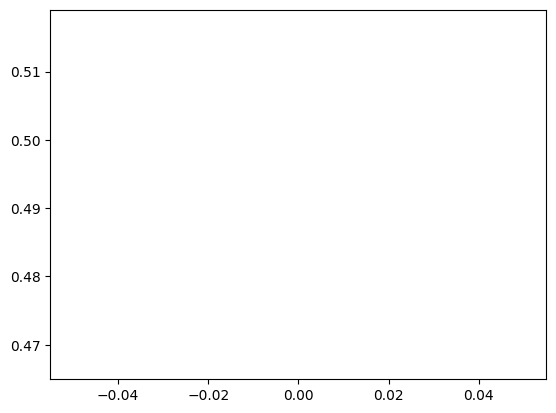

In [264]:
plt.plot(((np.array(res)==1).sum()/len(res)))